In [1]:
!pip install mnist1d

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import time, copy, os
import torch
import torch.nn.functional as F

import mnist1d


In [3]:
args = mnist1d.get_dataset_args()
args.num_samples = 10000
data = mnist1d.get_dataset(args=args, download=False, regenerate=True)

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...


In [4]:
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


In [5]:
def get_functional_mlp(args):
  D, H, O = args.input_size, args.hidden_size, args.output_size
  linear1, linear2 = torch.nn.Linear(D,H), torch.nn.Linear(H,O)
  params = [linear1.weight, linear1.bias, linear2.weight, linear2.bias]
  params = [torch.Tensor(p.reshape(-1)) for p in params]
  param_vec = torch.cat(params).to(args.device)

  def forward_fn(x, param_vec, afunc):
    pointer = 0
    W1 = param_vec[pointer:pointer+D*H].reshape(H,D)
    pointer += D*H
    b1 = param_vec[pointer:pointer+H].reshape(1,-1)
    pointer += H
    W2 = param_vec[pointer:pointer+H*O].reshape(O,H)
    pointer += O*H
    b2 = param_vec[pointer:pointer+O].reshape(1,-1)

    h = afunc((W1 @ x.t()).t() + b1)
    h = h + .1*(2*torch.rand(*b1.shape).to(b1.device)-1)
    logits = (W2 @ h.t()).t() + b2
    return logits
  return param_vec, forward_fn

In [6]:
def accuracy(model, inputs, targets):
  preds = model(inputs).argmax(-1).cpu().numpy()
  targets = targets.cpu().numpy().astype(np.float32)
  return 100*sum(preds==targets)/len(targets)

def inner_optimization(model, args, data, afunc):
  torch.manual_seed(args.seed)
  (param_vec, fwd_fn) = model
  x_train, x_test = torch.Tensor(data['x']), torch.Tensor(data['x_test'])
  y_train, y_test = torch.LongTensor(data['y']), torch.LongTensor(data['y_test'])
  x_train, x_test, y_train, y_test = [v.to(args.device) for v in [x_train, x_test, y_train, y_test]]

  criterion = torch.nn.CrossEntropyLoss()
  results = {'train_losses': [], 'test_acc': []}
  avg_sq_grad = torch.ones_like(param_vec)

  for step in range(args.total_steps):
    bix = (args.batch_ix + (step*args.batch_size))%len(x_train)
    x, y = x_train[bix:bix+args.batch_size], y_train[bix:bix+args.batch_size]
    loss = criterion(fwd_fn(x, param_vec, afunc), y)

    grads = torch.autograd.grad(loss, param_vec, retain_graph=True, create_graph=True)[0]
    avg_sq_grad = avg_sq_grad * args.mu + grads**2 * (1 - args.mu)
    param_vec = param_vec - args.learning_rate * grads/(torch.sqrt(avg_sq_grad) + 1e-8)

    results['train_losses'].append(loss)
    if step % args.test_every:
      k = 500
      test_acc = accuracy(lambda x: fwd_fn(x, param_vec, afunc), x_test[:k], y_test[:k])
      results['test_acc'].append(test_acc)

  results['train_losses'] = torch.stack(results['train_losses'])
  results['test_acc'] = np.asarray(results['test_acc'])
  return results

In [7]:
base_activation = torch.nn.ELU()

def mlp_afunc(model, x):
  (param_vec, fwd_fn) = model
  x_hat = 0.2 * fwd_fn(x.reshape(-1, 1), param_vec, torch.tanh)
  x_hat = x_hat.reshape(*x.shape)
  return base_activation(x) + x_hat

def outer_optimization(inner_args, outer_args):
  torch.manual_seed(outer_args.seed)
  torch.cuda.manual_seed_all(outer_args.seed)
  (outer_param_vec, outer_fwd_fn) = outer_model = get_functional_mlp(outer_args)

  t0 = time.time()
  results = {'inner_test_accs':[], 'train_losses':[], 'inner_afunc':[], 'grad_norm':[]}
  momentum = torch.zeros_like(outer_param_vec)
  for step in range(outer_args.total_steps):
    inner_afunc = lambda x: mlp_afunc(outer_model, x)
    inner_model = get_functional_mlp(inner_args)
    inner_results = inner_optimization(inner_model, inner_args, data, inner_afunc)

    (outer_param_vec, outer_fwd_fn) = outer_model
    outer_loss = inner_results['train_losses'][-200:].mean()
    outer_grads = torch.autograd.grad(outer_loss, outer_param_vec)[0]
    outer_grads = outer_grads.clamp(-1e-1, 1e-1)

    momentum = outer_args.mu * momentum + outer_grads
    outer_param_vec = outer_param_vec - outer_args.learning_rate * momentum
    outer_model = (outer_param_vec, outer_fwd_fn)

    results['train_losses'].append(outer_loss.item())
    if step % outer_args.print_every == 0:
      t1 = time.time()
      grad_norm = outer_grads @ outer_grads
      results['grad_norm'].append(grad_norm.item())
      print('step: {}, dt: {:.1f}s, meta_grad_norm: {:.1e}, mean_inner_loss: {:.3e}, final_inner_loss: {:.3e}, test_acc: {:.1f}'
          .format(step, t1-t0, grad_norm.item(),
                  results['train_losses'][-1],
                  inner_results['train_losses'][-1],
                  inner_results['test_acc'][-1]))
      t0 = t1

    x_fn = torch.linspace(-5,5,steps=100).to(outer_args.device)
    x_fn, y_fn = x_fn.cpu().numpy(), inner_afunc(x_fn).detach().cpu().numpy()
    results['inner_afunc'].append([x_fn, y_fn])
    results['inner_test_accs'].append(inner_results['test_acc'])

  return results

In [8]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

def get_inner_args(as_dict=False):
  arg_dict = {'input_size': 40,
              'hidden_size': 128,
              'output_size': 10,
              'batch_size': 100,
              'total_steps': 301,
              'test_every': 400,
              'learning_rate': 1e-2,
              'seed': 0,
              'device': DEVICE,
              'mu': 0.7,
              'batch_ix': 0}
  return arg_dict if as_dict else ObjectView(arg_dict)

def get_outer_args(as_dict=False):
  arg_dict = {'input_size': 1,
              'hidden_size': 100,
              'output_size': 1,
              'batch_size': 1,
              'learning_rate': 3e-1,
              'mu': 0.0,
              'total_steps': 301,
              'print_every': 1,
              'device': DEVICE,
              'seed': 0}
  return arg_dict if as_dict else ObjectView(arg_dict)
inner_args, outer_args = get_inner_args(), get_outer_args()
mnist1d.set_seed(outer_args.seed)

In [9]:
results_mu_7 = outer_optimization(inner_args, outer_args)

step: 0, dt: 2.9s, meta_grad_norm: 2.2e-01, mean_inner_loss: 1.359e+00, final_inner_loss: 1.341e+00, test_acc: 48.8
step: 1, dt: 2.6s, meta_grad_norm: 9.9e-02, mean_inner_loss: 1.310e+00, final_inner_loss: 1.255e+00, test_acc: 51.2
step: 2, dt: 4.5s, meta_grad_norm: 1.2e-01, mean_inner_loss: 1.279e+00, final_inner_loss: 1.191e+00, test_acc: 53.0
step: 3, dt: 2.7s, meta_grad_norm: 1.5e-01, mean_inner_loss: 1.240e+00, final_inner_loss: 1.134e+00, test_acc: 56.2
step: 4, dt: 1.8s, meta_grad_norm: 1.5e-01, mean_inner_loss: 1.196e+00, final_inner_loss: 1.080e+00, test_acc: 58.8
step: 5, dt: 1.7s, meta_grad_norm: 1.5e-01, mean_inner_loss: 1.149e+00, final_inner_loss: 1.038e+00, test_acc: 59.8
step: 6, dt: 1.8s, meta_grad_norm: 1.0e-01, mean_inner_loss: 1.108e+00, final_inner_loss: 1.019e+00, test_acc: 61.2
step: 7, dt: 2.0s, meta_grad_norm: 5.9e-02, mean_inner_loss: 1.081e+00, final_inner_loss: 1.016e+00, test_acc: 61.4
step: 8, dt: 2.0s, meta_grad_norm: 4.1e-02, mean_inner_loss: 1.064e+00, 

In [10]:
import pickle

# Save results using pickle
with open('results_mu_7.pkl', 'wb') as f:
    pickle.dump(results_mu_7, f)

print("Results saved to 'results_mu_7.pkl'")


Results saved to 'results_mu_7.pkl'


In [11]:
# Load results from pickle file
with open('results_mu_7.pkl', 'rb') as f:
    loaded_results = pickle.load(f)

print("Results loaded successfully!")


Results loaded successfully!


In [12]:
afuncs = [torch.relu, lambda x: x * torch.sigmoid(x), torch.nn.ELU(),
          torch.nn.Softplus(), torch.tanh, torch.sigmoid]
afunc_names = ['relu', 'swish', 'elu', 'softplus', 'tanh', 'sigmoid']
afunc_colors = ['yellow', 'orange', 'red', 'purple', 'blue', 'green']

baseline_results = []
results_mu_7['baselines'] = []

for i, f in enumerate(afuncs):
    torch.manual_seed(inner_args.seed)
    inner_model = get_functional_mlp(inner_args)
    r = inner_optimization(inner_model, inner_args, data, afunc=f)
    baseline_results.append(r)
    results_mu_7['baselines'] += [(afunc_names[i], r['test_acc'][-1], afunc_colors[i])]

In [13]:
print(np.mean(results_mu_7['train_losses']))
print(afunc_names)
[r['train_losses'].detach().cpu().numpy().mean() for r in baseline_results]

0.9274931306458787
['relu', 'swish', 'elu', 'softplus', 'tanh', 'sigmoid']


[1.367965, 1.3992144, 1.5029104, 1.6818708, 1.5553429, 1.7812232]

In [14]:
# saving
run_tag = 'steps{:.0f}_seed{:.0f}_lr{:.0e}_elu_init' \
        .format(outer_args.total_steps, outer_args.seed,
                outer_args.learning_rate)
mnist1d.to_pickle(results_mu_7, path='/content' + run_tag)
print('saved: {}'.format(run_tag))

saved: steps301_seed0_lr3e-01_elu_init


In [15]:
# loading
run_tag = run_tag
results = mnist1d.from_pickle(path='/content' + run_tag)
print('loaded: {}'.format(run_tag))

loaded: steps301_seed0_lr3e-01_elu_init


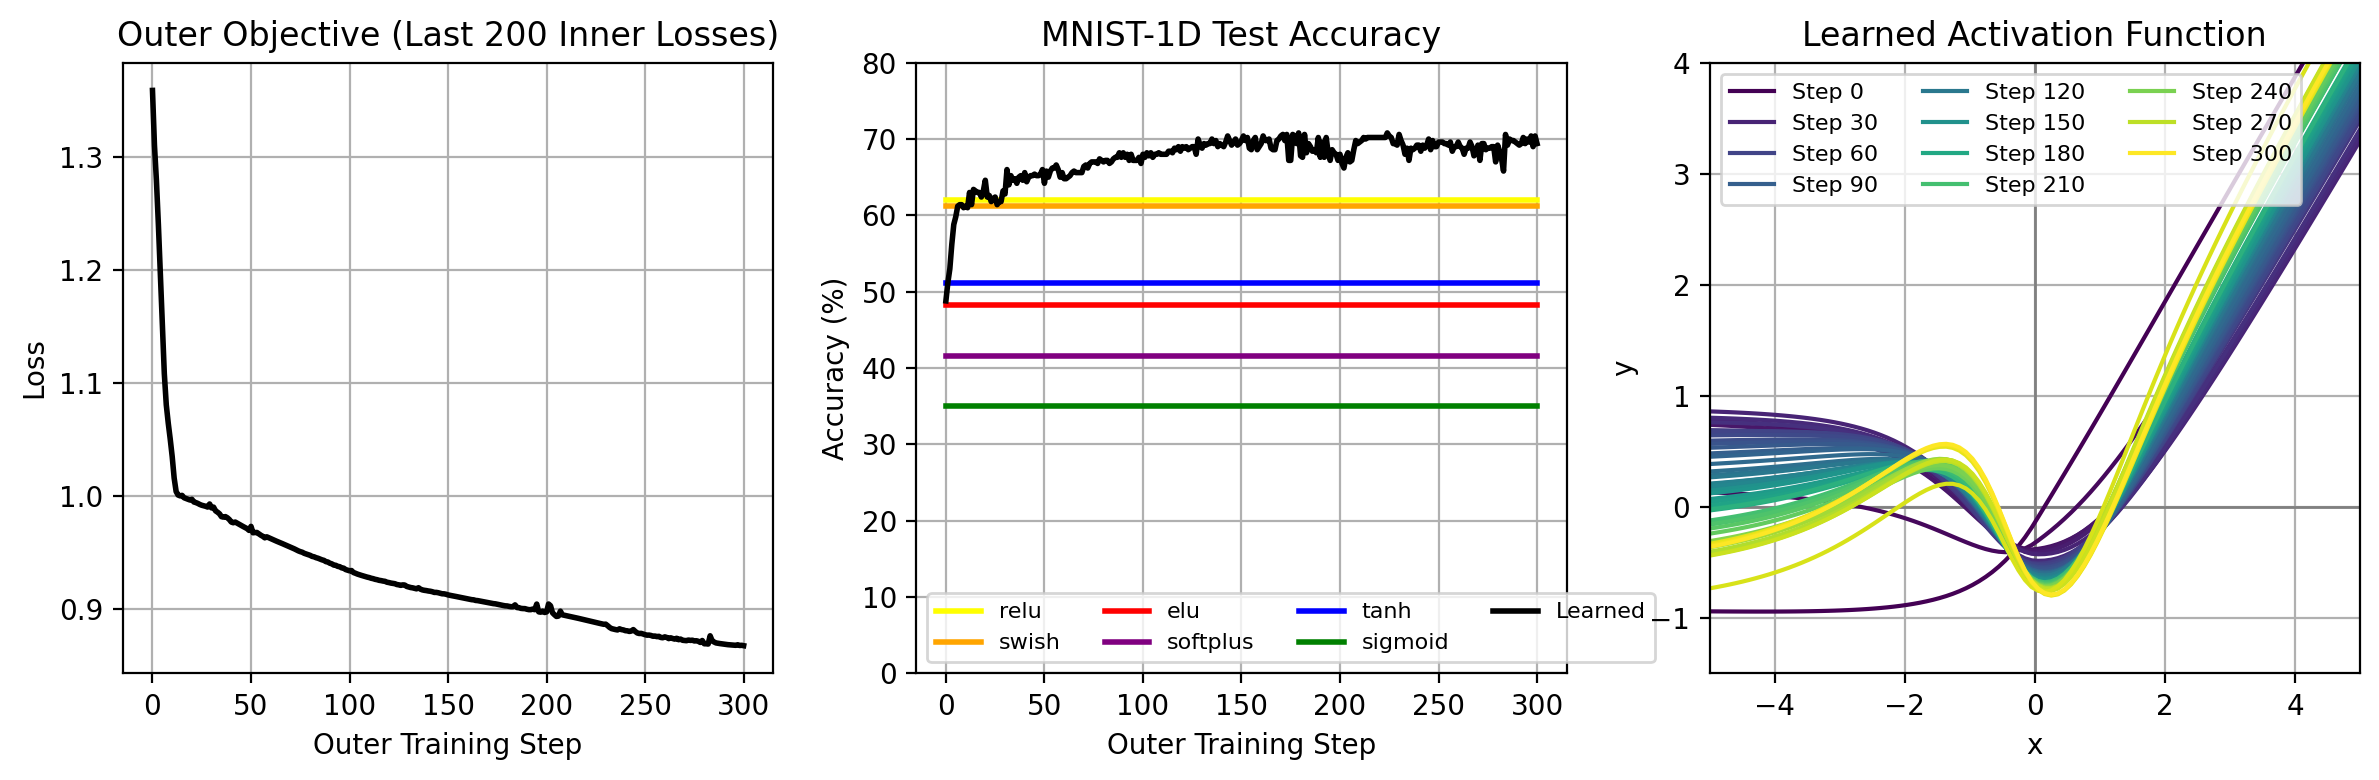

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12, 4), dpi=200)
t = range(0, outer_args.total_steps, outer_args.print_every)

# Subplot 1: Outer objective (last 200 inner losses)
plt.subplot(1, 3, 1)
plt.plot(results['train_losses'], 'k-', label='Final Training Loss', linewidth=2)
plt.title('Outer Objective (Last 200 Inner Losses)', fontsize=12)
plt.xlabel("Outer Training Step", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.grid(True)
plt.tight_layout()

# Subplot 2: MNIST-1D test accuracy
plt.subplot(1, 3, 2)
meta_test_acc = [r[-1] for r in results['inner_test_accs']]
for (name, acc, color) in results['baselines']:
    plt.plot(t, [acc] * len(t), '-', color=color, label=name, linewidth=2)
plt.plot(t, meta_test_acc, 'k-', label='Learned', linewidth=2)
plt.title('MNIST-1D Test Accuracy', fontsize=12)
plt.xlabel("Outer Training Step", fontsize=10)
plt.ylabel("Accuracy (%)", fontsize=10)
plt.ylim(0, 80)
plt.legend(fontsize=8, ncol=4)
plt.grid(True)

# Subplot 3: Learned activation function
plt.subplot(1, 3, 3)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)

N = len(results['inner_afunc'])
colors = plt.cm.viridis(np.linspace(0, 1, N))
for i, (x, y) in enumerate(results['inner_afunc']):
    if i % (N // 50) == 0 or i == len(results['inner_afunc']):
        l, m = 0, 100
        label = 'Step {}'.format(i * outer_args.print_every) if i % (N // 10) == 0 or i == len(results['inner_afunc']) else None
        plt.plot(x[l:m], y[l:m], color=colors[i], label=label)

plt.legend(fontsize=8, ncol=3)
plt.title("Learned Activation Function", fontsize=12)
plt.xlim(-5, 5)
plt.ylim(-1.5, 4)
plt.xlabel("x", fontsize=10)
plt.ylabel("y", fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
def polyfunc(coeffs):
  def f(x):
    r = 0.*x
    for i, c in enumerate(coeffs[::-1]):
      r += c * x**i
    return r
  return f

def get_approx_afun():
  def f(x):
    seg0, seg1, seg2, seg3, seg4, seg5 = [.15, .9], [-.25, 0.1], [-1.2, -.85], [-.5, -.75], [0.2, -.85], [1.2, -1.4]
    y = (x < -2) * polyfunc(seg0)(x) + \
        (x > -2) * (x < -1) * polyfunc(seg1)(x) + \
        (x > -1) * (x < -0.25) * polyfunc(seg2)(x) + \
        (x > -0.25) * (x < 0.1) * polyfunc(seg3)(x) + \
        (x > 0.1) * (x < .6) * polyfunc(seg4)(x) + \
        (x > .6) * polyfunc(seg5)(x)
    return y
  return f

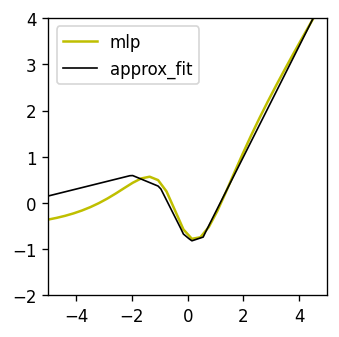

In [18]:

fig = pl.figure(figsize=[3,3],dpi=120)

approx_afunc = get_approx_afun()
x, y = results['inner_afunc'][-1]
plt.plot(x[::3], y[::3], 'y-', label='mlp')
x_ = np.linspace(-5,5,100)
plt.plot(x_, approx_afunc(x_), 'k-', label='approx_fit', linewidth=1)
plt.legend() ; plt.xlim(-5,5) ; plt.ylim(-2,4) ; plt.show()

In [19]:
torch.manual_seed(inner_args.seed)
inner_model = get_functional_mlp(inner_args)
poly_results = inner_optimization(inner_model, inner_args, data, afunc=approx_afunc)
results['baselines'] += [('approx_fit', poly_results['test_acc'][-1], 'grey')]
poly_results['test_acc'][-1]

66.8